## Football MC season simulation and visualisation
Thanks for looking at this project, here we run a Monte Carlo simulation heavily inspired and slimmed down from the five thirty eight model to visualise the predicted winner of the league by previous results.

We use two variables to adjust the absolute goals scored metric, recent form and home advantage. We allow manual changing of the weighting of these variables and show a very simple ML output of what was the truest representation of these variables for the season.

Finally if we look at the 2020 season, we then expand this ML application to show the decrease in home advantage following the social distancing requirements due to the COVID-19 outbreak.

In [3]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import pandas as pd
import numpy as np
import os
import itertools
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

url = 'https://raw.githubusercontent.com/BenBowring/Football/main/E0_21.csv'
data = pd.read_csv(url, index_col='Date')
data.index = pd.to_datetime(data.index, format='%d/%m/%Y')

In [27]:
class Football:
    
    def __init__(self, data):
        
        self.data = data
        self.data.index = pd.to_datetime(data.index, format='%d/%m/%Y')
        
        self.home_labels = ['GF', 'GA', 'Opp']
        self.home_cols = ['FTHG', 'FTAG', 'AwayTeam']
        
        self.away_labels = ['GF', 'GA', 'Opp']
        self.away_cols = ['FTAG', 'FTHG', 'HomeTeam']
        
        self.teams = data['HomeTeam'].unique()

    def get_history(self, date):
        
        self.doi = date
        self.doi_delta = self.doi + pd.Timedelta("1 days")

        self.season = self.data.loc[:self.doi]
        self.season_remaining = self.data.loc[self.doi_delta:]
        self.matchups_remaining = [[x[0], x[1]] for x in zip(self.season_remaining['HomeTeam'], self.season_remaining['AwayTeam'])]
        
        self.dict_goals = {}
        
        for team in self.teams:
        
            home_games = self.season[self.season['HomeTeam'] == team][self.home_cols]
            home_games.columns = self.home_labels
            home_games['H/A'] = 'H'
            
            away_games = self.season[self.season['AwayTeam'] == team][self.away_cols]
            away_games.columns = self.away_labels
            away_games['H/A'] = 'A'
        
            self.dict_goals[team] = pd.concat([home_games, away_games], axis = 0).sort_index()
        
        self.df_total = pd.DataFrame({'Average Goals For': [self.dict_goals[team]['GF'].mean() for team in self.teams],
                               'Average Goals Against': [self.dict_goals[team]['GA'].mean() for team in self.teams],
                               'Predicted Goals For': [np.mean([self.dict_goals[opp]['GA'].mean() for opp in self.dict_goals[team]['Opp']]) for team in self.teams],
                               'Predicted Goals Against': [np.mean([self.dict_goals[opp]['GF'].mean() for opp in self.dict_goals[team]['Opp']]) for team in self.teams]}, 
                              index = self.teams)
        
        self.df_home = pd.DataFrame({'Average Goals For': [self.dict_goals[team]['GF'][self.dict_goals[team]['H/A'] == 'H'].mean() for team in self.teams],
                               'Average Goals Against': [self.dict_goals[team]['GA'][self.dict_goals[team]['H/A'] == 'H'].mean() for team in self.teams],
                               'Predicted Goals For': [np.mean([self.dict_goals[opp]['GA'].mean() for opp in self.dict_goals[team]['Opp'][self.dict_goals[team]['H/A'] == 'H']]) for team in self.teams],
                               'Predicted Goals Against': [np.mean([self.dict_goals[opp]['GF'].mean() for opp in self.dict_goals[team]['Opp'][self.dict_goals[team]['H/A'] == 'H']]) for team in self.teams]}, 
                              index = self.teams)
        
        self.df_away = pd.DataFrame({'Average Goals For': [self.dict_goals[team]['GF'][self.dict_goals[team]['H/A'] == 'A'].mean() for team in self.teams],
                               'Average Goals Against': [self.dict_goals[team]['GA'][self.dict_goals[team]['H/A'] == 'A'].mean() for team in self.teams],
                               'Predicted Goals For': [np.mean([self.dict_goals[opp]['GA'].mean() for opp in self.dict_goals[team]['Opp'][self.dict_goals[team]['H/A'] == 'A']]) for team in self.teams],
                               'Predicted Goals Against': [np.mean([self.dict_goals[opp]['GF'].mean() for opp in self.dict_goals[team]['Opp'][self.dict_goals[team]['H/A'] == 'A']]) for team in self.teams]}, 
                              index = self.teams)
        
        self.df_form = pd.DataFrame({'Goals For': [self.dict_goals[team]['GF'].ewm(alpha=0.5).mean().iloc[-1] for team in self.teams],
                               'Goals Against': [self.dict_goals[team]['GA'].ewm(alpha=0.5).mean().iloc[-1] for team in self.teams]}, 
                              index = self.teams)
        
        self.df_total['Adjusted Goals For'] = self.df_total.apply(lambda x: (x['Average Goals For']/x['Predicted Goals For']) * x['Average Goals For'], axis = 1)
        self.df_total['Adjusted Goals Against'] = self.df_total.apply(lambda x: (x['Average Goals Against']/x['Predicted Goals Against']) * x['Average Goals Against'], axis = 1) 
        
        self.df_home['Adjusted Goals For'] = self.df_home.apply(lambda x: (x['Average Goals For']/x['Predicted Goals For']) * x['Average Goals For'], axis = 1)
        self.df_home['Adjusted Goals Against'] = self.df_home.apply(lambda x: (x['Average Goals Against']/x['Predicted Goals Against']) * x['Average Goals Against'], axis = 1) 
        
        self.df_away['Adjusted Goals For'] = self.df_away.apply(lambda x: (x['Average Goals For']/x['Predicted Goals For']) * x['Average Goals For'], axis = 1)
        self.df_away['Adjusted Goals Against'] = self.df_away.apply(lambda x: (x['Average Goals Against']/x['Predicted Goals Against']) * x['Average Goals Against'], axis = 1) 
        
    
    def get_poiss(self, matchups, home_adv = 0.5, form_adv = 0.5):
        
        away_adv = 1 - home_adv
        anti_form = 1 - form_adv
        
        self.df_adjust = pd.DataFrame({'Home Team': [x[0] for x in matchups],
                                  'Away Team': [x[1] for x in matchups],
                                  'Pred Home Goals For': [home_adv * self.df_home['Adjusted Goals For'].loc[x[0]] + away_adv * self.df_away['Adjusted Goals For'].loc[x[0]] for x in matchups],
                                   'Pred Home Goals Against': [home_adv * self.df_home['Adjusted Goals Against'].loc[x[0]] + away_adv * self.df_away['Adjusted Goals Against'].loc[x[0]] for x in matchups],
                                   'Pred Away Goals For': [home_adv * self.df_away['Adjusted Goals For'].loc[x[1]] + away_adv * self.df_home['Adjusted Goals For'].loc[x[1]] for x in matchups],
                                   'Pred Away Goals Against': [home_adv * self.df_away['Adjusted Goals Against'].loc[x[1]] + away_adv * self.df_home['Adjusted Goals Against'].loc[x[1]] for x in matchups],
                                   'Home Form For': [self.df_form['Goals For'].loc[x[0]] for x in matchups],
                                   'Home Form Against': [self.df_form['Goals Against'].loc[x[0]] for x in matchups],
                                   'Away Form For': [self.df_form['Goals For'].loc[x[1]] for x in matchups],
                                   'Away Form Against': [self.df_form['Goals Against'].loc[x[1]] for x in matchups]},
                                     index = self.season_remaining.index)
        
        df_out = pd.DataFrame({'Home Team': self.df_adjust['Home Team'],
                               'Away Team': self.df_adjust['Away Team'],
                               'Home Goals': self.df_adjust.apply(lambda x: (anti_form * (home_adv * x['Pred Home Goals For'] + away_adv *  x['Pred Away Goals Against'])
                                                                        + form_adv * np.mean(x[['Home Form For', 'Away Form Against']])), axis = 1),
                               
                               'Away Goals': self.df_adjust.apply(lambda x: (anti_form * (home_adv * x['Pred Away Goals For'] + away_adv *  x['Pred Home Goals Against'])
                                                                        + form_adv * np.mean(x[['Away Form For', 'Home Form Against']])), axis = 1)})
                              
        return(df_out)


    def mse_run(self, granular = 0.2):
        
        if len(self.matchups_remaining) > 0:
        
            variables = np.arange(0, 1 + granular, granular)
    
            mse_full = pd.DataFrame(columns = variables, index = variables)
    
            for entry in itertools.product(variables, variables):
                
                home_adv, form_adv = entry[0], entry[1] 
                
                score_pred = self.get_poiss(self.matchups_remaining, home_adv, form_adv)
                
                mse_df = pd.DataFrame({'Home Team': score_pred['Home Team'],
                                       'Away Team': score_pred['Away Team'],
                                       'Actual Home': self.season_remaining['FTHG'],
                                       'Actual Away': self.season_remaining['FTAG'],
                                       'Predicted Home': score_pred['Home Goals'],
                                       'Predicted Away': score_pred['Away Goals']})
                
                y_true = mse_df[['Actual Home', 'Actual Away']]
                y_pred = mse_df[['Predicted Home', 'Predicted Away']]
                
                mse_full.loc[home_adv, form_adv] = mean_squared_error(y_true, y_pred)
            
            mse_full = mse_full.apply(pd.to_numeric)
    
            opt_home = mse_full.min(axis = 1).idxmin()
            opt_form = mse_full.min(axis = 0).idxmin()
        
            return [opt_home, opt_form, mse_full]
        
        else:
            
            print("Season Finished")
            
            return [np.nan, np.nan, np.nan]
    
        

In [28]:
evolution = data.index[310:].unique()

optimal_weights = pd.DataFrame(columns = ['Home Advantage', 'Form Advantage'],
                               index = evolution)

its_alive = Football(data)

surface_mse = {}

for date in evolution:
    
    print(date)
    
    its_alive.get_history(date)
    
    mse_temp = its_alive.mse_run()
    
    optimal_weights.loc[date] = its_alive.mse_run()[0:2]
    surface_mse[date] = mse_temp[2]

2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
Season Finished
Season Finished


<AxesSubplot:xlabel='Date'>

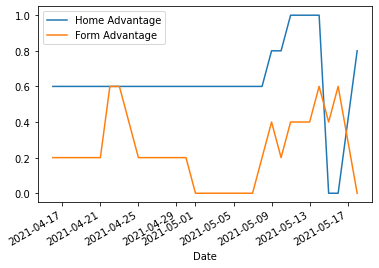

In [29]:
optimal_weights.plot()

<ipython-input-31-5a9c61c7f05f>:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure().gca(projection='3d')


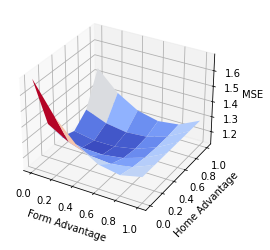

In [31]:
date = evolution[0]
variables = np.arange(0, 1.2, 0.2)
mse_full = surface_mse[date]

Y = variables
X = variables
X, Y = np.meshgrid(X, Y)

threedee = plt.figure().gca(projection='3d')
threedee.plot_surface(X, Y, np.array(mse_full), cmap=plt.cm.coolwarm)
threedee.set_xlabel('Form Advantage')
threedee.set_ylabel('Home Advantage')
threedee.set_zlabel('MSE')

plt.show()
